# DAY-AHEAD CONDITIONAL LINEAR MODEL

## 2025 ENTSO-E data BZN|NL

Residual load x price correlation depending on hour, season and market regime

In [ ]:
#Load data from baseline models

%store -r price_load
%store -r morning_price_load
%store -r afternoon_price_load
%store -r night_price_load
%store -r spring_price_load
%store -r summer_price_load
%store -r autumn_price_load
%store -r winter_price_load

price_load

In [22]:
import pandas as pd
import statsmodels.formula.api as smf
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

price_load["season"] = price_load["Month"].apply(month_to_season)

price_load = price_load.rename(columns={
    "Residual load day-ahead (MW)": "residual_load",
    "Price": "price"
})

price_load["hour"] = price_load["Hour"].astype("category")
price_load["season"] = price_load["season"].astype("category")

model = smf.ols(
    formula="""
    price ~ residual_load
          + C(hour)
          + C(season)
          + residual_load:C(season)
    """,
    data=price_load
).fit()

In [ ]:
#Testing block: compare my prediction model outcome for January 2025 against observed data in January 2026

#NEXT: GET DAY-AHEAD RESIDUAL LOAD FOR JAN 2026 ENTSO-E, FEED THE MODEL, COMPARE WITH OSBERVED PRICES

repo_root = Path("..").resolve()
sys.path.append(str(repo_root))

#Load 2026 ENTSO-E data
from Source.load_data import load_2026

df_market = load_2026()
price_load_jan2026_market = price_load_jan2026_market.T.drop_duplicates().T

mtu = df_market['MTU (CET/CEST)'].iloc[:,0]
df_market['Time'] = mtu.str.split(' - ').str[0]
df_market['Time'] = df_market['Time'].str.replace(r"\s*\(.*\)", "", regex=True).str.strip()
df_market['Time'] = pd.to_datetime(df_market['Time'], dayfirst=True)

df_market['Hour'] = df_market['Time'].dt.hour
df_market['Day'] = df_market['Time'].dt.day
df_market['Month'] = df_market['Time'].dt.month

df_market.head()
cols = [
    'Day-ahead Total Load Forecast (MW)',
    'Day-ahead offshore wind (MW)',
    'Day-ahead onshore wind (MW)',
    'Day-ahead solar (MW)',
    'Actual Total Load (MW)',
    'Actual offshore wind (MW)',
    'Actual onshore wind (MW)',
    'Actual solar (MW)'
]

df_market[cols] = df_market[cols].apply(
    pd.to_numeric,
    errors='coerce'
)

residual_load_da = df_market['Day-ahead Total Load Forecast (MW)'] - df_market['Day-ahead offshore wind (MW)'] - df_market['Day-ahead onshore wind (MW)'] - df_market['Day-ahead solar (MW)']
residual_load_actual = df_market['Actual Total Load (MW)'] - df_market['Actual offshore wind (MW)'] - df_market['Actual onshore wind (MW)'] - df_market['Actual solar (MW)']

price_load_2026 = pd.DataFrame({'Residual load actual (MW)':residual_load_actual,'Residual load day-ahead (MW)':residual_load_da,'Price': df_market['Day-ahead Price (EUR/MWh)']})
price_load_2026['Month'] = df_market['Month']
price_load_2026['Hour'] = df_market['Hour']

price_load_2026.head()
price_load_2026 = price_load_2026.rename(columns={
    "Residual load day-ahead (MW)": "residual_load",
    "Hour": "hour",
    "Month": "month",
    "Price": "price"  # optional, for evaluation
})

def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

price_load_2026["season"] = price_load_2026["month"].apply(month_to_season)

#Feed the model

pred_2026 = model.get_prediction(price_load_2026)
pred_df_2026 = pred_2026.summary_frame(alpha=0.1)

price_load_2026["price_hat"] = pred_df_2026["mean"]
price_load_2026["price_lo"] = pred_df_2026["mean_ci_lower"]
price_load_2026["price_hi"] = pred_df_2026["mean_ci_upper"]

price_load_jan2026 = price_load_2026[price_load_2026['month'] == 1]

price_load_jan2026.loc[:, 'price'] = pd.to_numeric(price_load_jan2026['price'], errors='coerce')
print(price_load_jan2026.head())


   Residual load actual (MW)  residual_load  price  month  hour  season  \
0                    6878.10        7134.07  72.91      1     0  winter   
1                    6572.63        7087.09  69.16      1     0  winter   
2                    6460.86        7025.81   59.8      1     0  winter   
3                    6349.68        7116.41   51.9      1     0  winter   
4                    6187.77        7019.76  75.66      1     1  winter   

   price_hat   price_lo   price_hi  
0  55.545337  53.817311  57.273363  
1  54.984022  53.248394  56.719650  
2  54.251851  52.506207  55.997495  
3  55.334336  53.603460  57.065212  
4  52.678507  50.945693  54.411321  


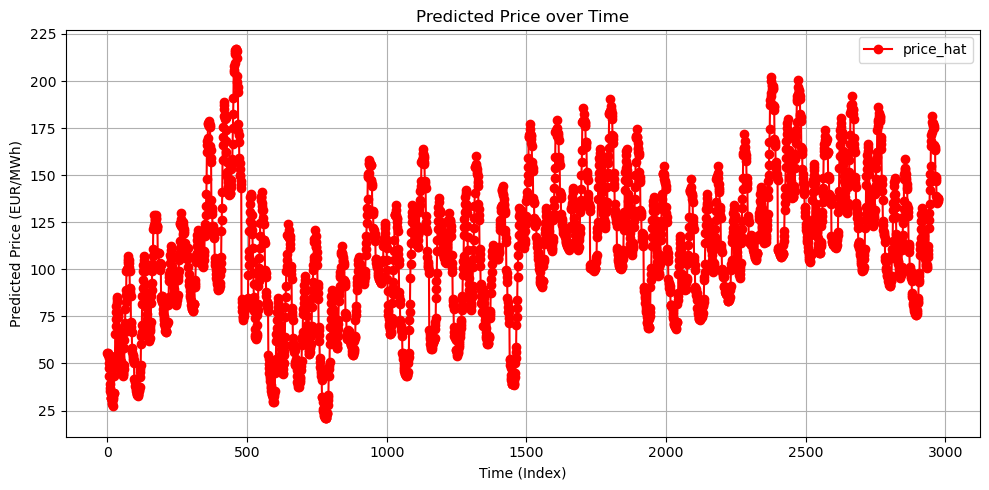

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(price_load_jan2026.index, price_load_jan2026['price_hat'], color='red', marker='o', label='price_hat')

plt.xlabel('Time (Index)')
plt.ylabel('Predicted Price (EUR/MWh)')
plt.title('Predicted Price over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

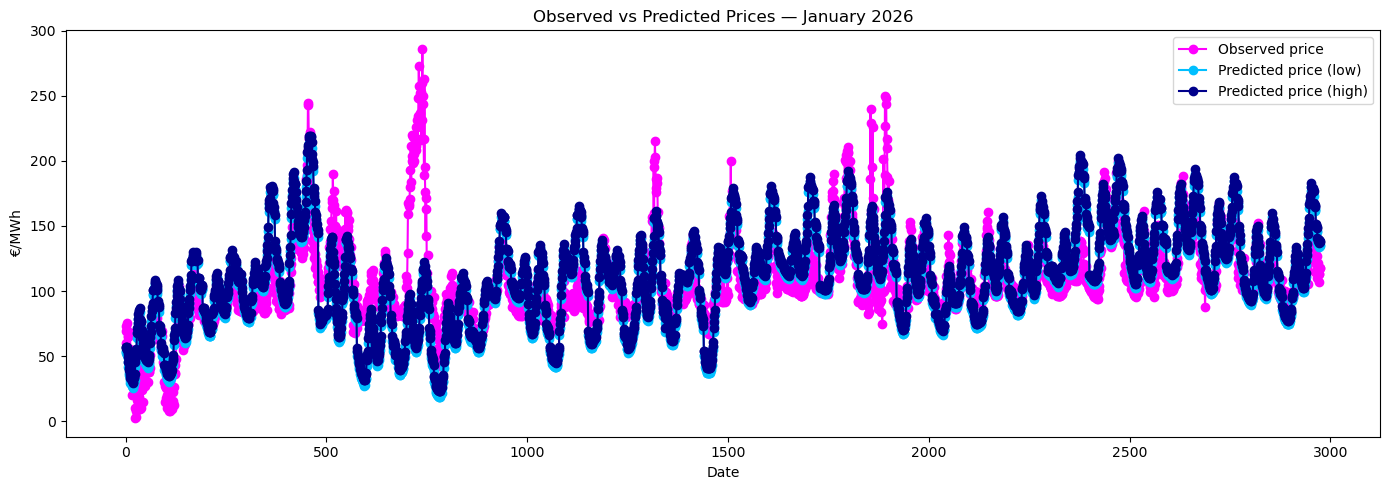

In [102]:
plt.figure(figsize=(14,5))
plt.plot(price_load_jan2026.index, price_load_jan2026["price"],color='fuchsia', marker='o', label="Observed price")
plt.plot(price_load_jan2026.index, price_load_jan2026["price_lo"],color='deepskyblue', marker='o', label="Predicted price (low)")
plt.plot(price_load_jan2026.index, price_load_jan2026["price_hi"],color='darkblue', marker='o', label="Predicted price (high)")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.title("Observed vs Predicted Prices — January 2026")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\nicola.leuratti\AppData\Local\Temp\ipykernel_36728\3295435240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_load_jan2026["error"] = (
C:\Users\nicola.leuratti\AppData\Local\Temp\ipykernel_36728\3295435240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_load_jan2026["abs_error"] = price_load_jan2026["error"].abs()
C:\Users\nicola.leuratti\AppData\Local\Temp\ipykernel_36728\3295435240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

<Axes: title={'center': 'Mean Absolute Error by Hour (€/MWh)'}, xlabel='hour'>

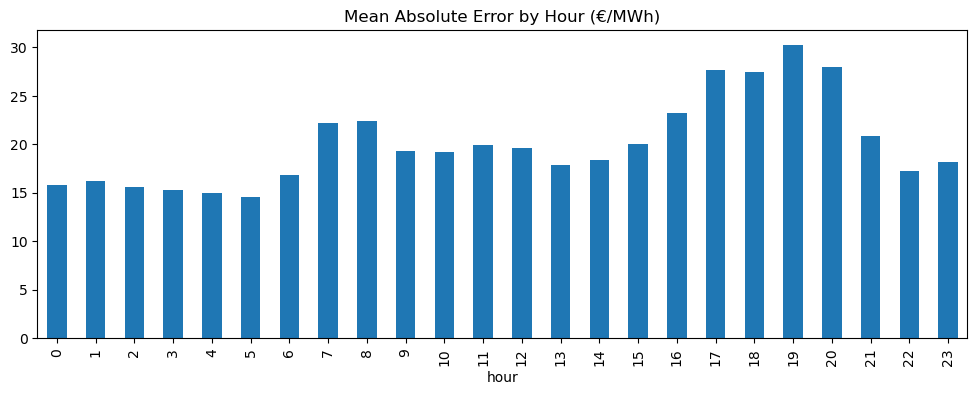

In [107]:
#Model accuracy

price_load_jan2026["error"] = (
    price_load_jan2026["price"]
    - price_load_jan2026["price_hat"]
)

price_load_jan2026["abs_error"] = price_load_jan2026["error"].abs()
price_load_jan2026["squared_error"] = price_load_jan2026["error"] ** 2


#MAE:
#RMSE:
#Bias:
# mae = price_load_jan2026["abs_error"].mean()
# rmse = (price_load_jan2026["squared_error"].mean()) ** 0.5
# bias = price_load_jan2026["error"].mean()
# print(f"MAE:  {mae:.2f} €/MWh")
# print(f"RMSE: {rmse:.2f} €/MWh")
# print(f"Bias: {bias:.2f} €/MWh")


error_by_hour = (
    price_load_jan2026
    .groupby("hour")["abs_error"]
    .agg(["mean", "median", "count"])
    .reset_index()
)

error_by_hour.plot(
    x="hour",
    y="mean",
    kind="bar",
    figsize=(12,4),
    legend=False,
    title="Mean Absolute Error by Hour (€/MWh)"
)


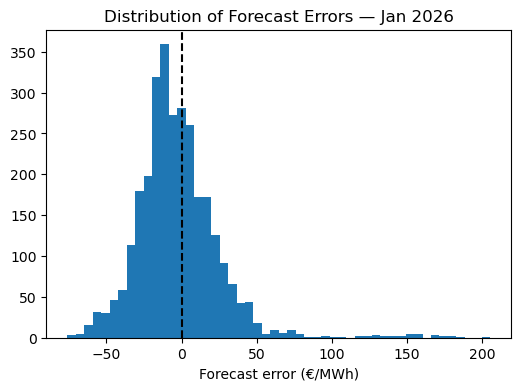

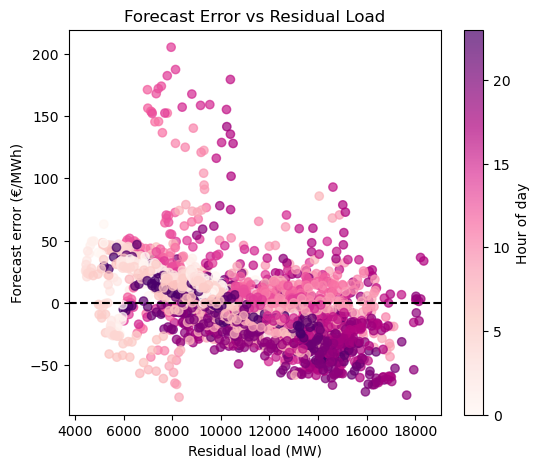

In [122]:
import matplotlib.pyplot as plt

#Distribution of forecast errors around the observed price:

plt.figure(figsize=(6,4))
plt.hist(price_load_jan2026["error"], bins=50)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Forecast error (€/MWh)")
plt.title("Distribution of Forecast Errors — Jan 2026")
plt.show()


#Correlation between forecast error and residual load:
plt.figure(figsize=(6,5))
plt.scatter(
    price_load_jan2026["residual_load"],
    price_load_jan2026["error"],
    c=price_load_jan2026["hour"], 
    cmap="RdPu",                 
    alpha=0.7
)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Residual load (MW)")
plt.ylabel("Forecast error (€/MWh)")
plt.title("Forecast Error vs Residual Load")
plt.colorbar(label="Hour of day")
plt.show()

Starting Targeted Residual Analysis...
Error patterns by subgroup:
               mean        std  count
subgroup                             
high_0    -12.11388   5.955569     16
high_1   -11.209258   3.471721     10
high_10    -5.14894  16.752016     63
high_11   -5.105638  16.469448     35
high_12    1.111502  13.121476     21
high_13    1.036546   9.847577     24
high_14   -5.651302  13.851318     33
high_15   -9.890663  22.531542     52
high_16  -13.312122  26.102123     79
high_17  -14.541476  30.635775     92

Training correction models for subgroups with sufficient data...
  low_0: val MAE=8.5€ (n=66)
  low_1: val MAE=5.9€ (n=73)
  low_2: val MAE=7.5€ (n=76)
  low_3: val MAE=7.9€ (n=76)
  low_4: val MAE=11.4€ (n=76)
  low_5: val MAE=5.4€ (n=75)
  low_6: val MAE=10.6€ (n=63)
  low_20: val MAE=8.0€ (n=24)
  low_21: val MAE=13.8€ (n=33)
  low_22: val MAE=4.9€ (n=43)
  low_23: val MAE=6.4€ (n=51)
  medium_8: val MAE=7.2€ (n=36)
  medium_9: val MAE=11.7€ (n=30)
  medium_19: val MAE

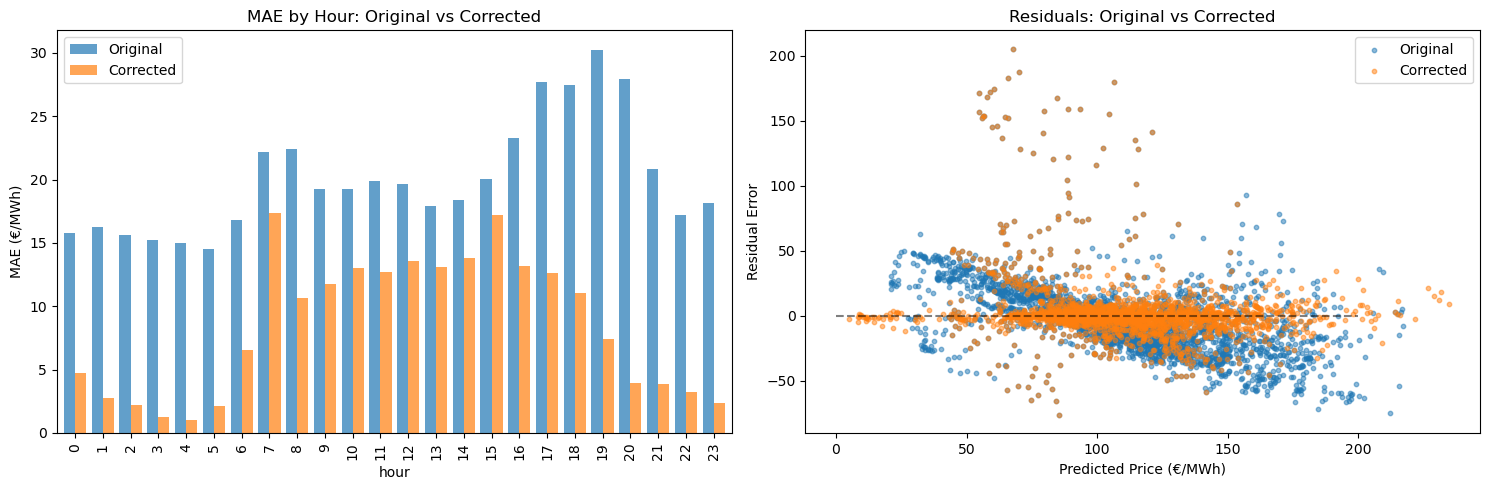


✅ Targeted Residual Analysis complete!
Your corrected predictions are now in: price_load_jan2026_corrected['price_hat_corrected']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


# 1. Define residual load regimes (quantiles of residual_load)
price_load_jan2026['residual_load_regime'] = pd.qcut(
    price_load_jan2026['residual_load'], 
    q=3, 
    labels=['low', 'medium', 'high']
)

# Create subgroup identifier (regime (3) x hour (24) = 72 subgroups)
price_load_jan2026['subgroup'] = (
    price_load_jan2026['residual_load_regime'].astype(str) + '_' + 
    price_load_jan2026['hour'].astype(str)
)


# 2. Prepare features for residual correction models
def create_residual_features(df):
    """Create lagged and interaction features for ML residual models"""
    df = df.copy()
    
    # Lagged residuals (autoregressive)
    df['error_lag1'] = df['error'].shift(1)
    df['error_lag24'] = df['error'].shift(24)  # previous day same hour
    df['residual_load_lag1'] = df['residual_load'].shift(1)
    
    # Interactions - create regime numeric first
    df['regime_code'] = df['residual_load_regime'].cat.codes.astype(float)
    
    # Interactions
    df['residual_load_x_hour'] = df['residual_load'] * df['hour']
    df['error_lag1_x_regime'] = df['error_lag1'] * df['regime_code']
    
    # Fill NaN SELECTIVELY - avoid categorical issues
    numeric_cols = [
        'error_lag1', 'error_lag24', 'residual_load_lag1',
        'residual_load_x_hour', 'error_lag1_x_regime', 'regime_code'
    ]
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    return df

price_load_jan2026 = create_residual_features(price_load_jan2026)

# Feature columns for ML models
feature_cols = [
    'hour', 'residual_load', 'month', 
    'error_lag1', 'error_lag24', 'residual_load_lag1',
    'residual_load_x_hour', 'error_lag1_x_regime', 'regime_code'
]


# 3. Train subgroup-specific ML correction models
correction_models = {}
subgroup_errors = {}

print("\nTraining correction models for subgroups with sufficient data...")
tscv = TimeSeriesSplit(n_splits=3)

for subgroup in price_load_jan2026['subgroup'].unique():
    subgroup_data = price_load_jan2026[price_load_jan2026['subgroup'] == subgroup].copy()
    
    if len(subgroup_data) > 20:  # Minimum samples per subgroup
        X = subgroup_data[feature_cols]
        y = subgroup_data['error']
        
        # Time-series split for training/validation
        model = RandomForestRegressor(n_estimators=20, random_state=42, max_depth=5)
        
        train_scores = []
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            train_scores.append(mean_absolute_error(y_val, y_pred))
        
        if np.mean(train_scores) < 15:  # Only keep models with reasonable performance
            correction_models[subgroup] = model
            subgroup_errors[subgroup] = np.mean(train_scores)
            print(f"  {subgroup}: val MAE={np.mean(train_scores):.1f}€ (n={len(subgroup_data)})")

print(f"\nTrained {len(correction_models)} correction models")


# 4. Apply walk-forward correction
def apply_residual_correction(df, models_dict):
    """Walk-forward prediction of corrections"""
    df = df.copy()
    df['price_hat_corrected'] = df['price_hat']
    
    for i in range(len(df)):
        subgroup = df.iloc[i]['subgroup']
        if subgroup in models_dict:
            # Use recent context for features (last 48 periods max)
            start_idx = max(0, i-48)
            recent_data = df.iloc[start_idx:i+1]
            X_i = recent_data[feature_cols].iloc[-1:]  # Most recent row
            
            correction = models_dict[subgroup].predict(X_i)[0]
            df.iloc[i, df.columns.get_loc('price_hat_corrected')] = (
                df.iloc[i]['price_hat'] + correction
            )
    
    df['error_corrected'] = df['price'] - df['price_hat_corrected']
    df['abs_error_corrected'] = df['error_corrected'].abs()
    return df

price_load_jan2026_corrected = apply_residual_correction(price_load_jan2026, correction_models)


# 5. Evaluate improvements
metrics_original = {
    'MAE': price_load_jan2026['abs_error'].mean(),
    'RMSE': np.sqrt(price_load_jan2026['squared_error'].mean()),
    'Bias': price_load_jan2026['error'].mean()
}

metrics_corrected = {
    'MAE': price_load_jan2026_corrected['abs_error_corrected'].mean(),
    'RMSE': np.sqrt((price_load_jan2026_corrected['error_corrected']**2).mean()),
    'Bias': price_load_jan2026_corrected['error_corrected'].mean()
}

improvement = {
    'MAE': (metrics_original['MAE'] - metrics_corrected['MAE']) / metrics_original['MAE'] * 100,
    'RMSE': (metrics_original['RMSE'] - metrics_corrected['RMSE']) / metrics_original['RMSE'] * 100,
    'Bias': abs(metrics_original['Bias']) - abs(metrics_corrected['Bias'])
}

print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"{'Metric':<10} {'Original':>8} {'Corrected':>9} {'Improvement':>10}")
print("-"*50)
for key in metrics_original:
    orig = metrics_original[key]
    corr = metrics_corrected[key]
    impr = improvement[key]
    print(f"{key:<10} {orig:>8.1f} {corr:>9.1f} {impr:>10.1f}%")


# 6. Visualize improvements by hour
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original vs Corrected MAE by hour
error_by_hour_corrected = (
    price_load_jan2026_corrected
    .groupby("hour")["abs_error_corrected"]
    .mean()
    .reset_index(name='mean_corrected')
)

error_comparison = error_by_hour.merge(
    error_by_hour_corrected, on='hour'
).melt(id_vars='hour', value_vars=['mean', 'mean_corrected'], 
       var_name='model', value_name='MAE')

error_comparison.pivot(index='hour', columns='model', values='MAE').plot(
    ax=ax1, kind='bar', width=0.8, alpha=0.7
)
ax1.set_title('MAE by Hour: Original vs Corrected')
ax1.legend(['Original', 'Corrected'])
ax1.set_ylabel('MAE (€/MWh)')

# Residual scatter (should be closer to zero line)
ax2.scatter(price_load_jan2026['price_hat'], price_load_jan2026['error'], 
           alpha=0.5, label='Original', s=10)
ax2.scatter(price_load_jan2026_corrected['price_hat_corrected'], 
           price_load_jan2026_corrected['error_corrected'], 
           alpha=0.5, label='Corrected', s=10)
ax2.plot([0, 200], [0, 0], 'k--', alpha=0.5)
ax2.set_xlabel('Predicted Price (€/MWh)')
ax2.set_ylabel('Residual Error')
ax2.legend()
ax2.set_title('Residuals: Original vs Corrected')

plt.tight_layout()
plt.show()

print("\n✅ Targeted Residual Analysis complete!")
print("Your corrected predictions are now in: price_load_jan2026_corrected['price_hat_corrected']")


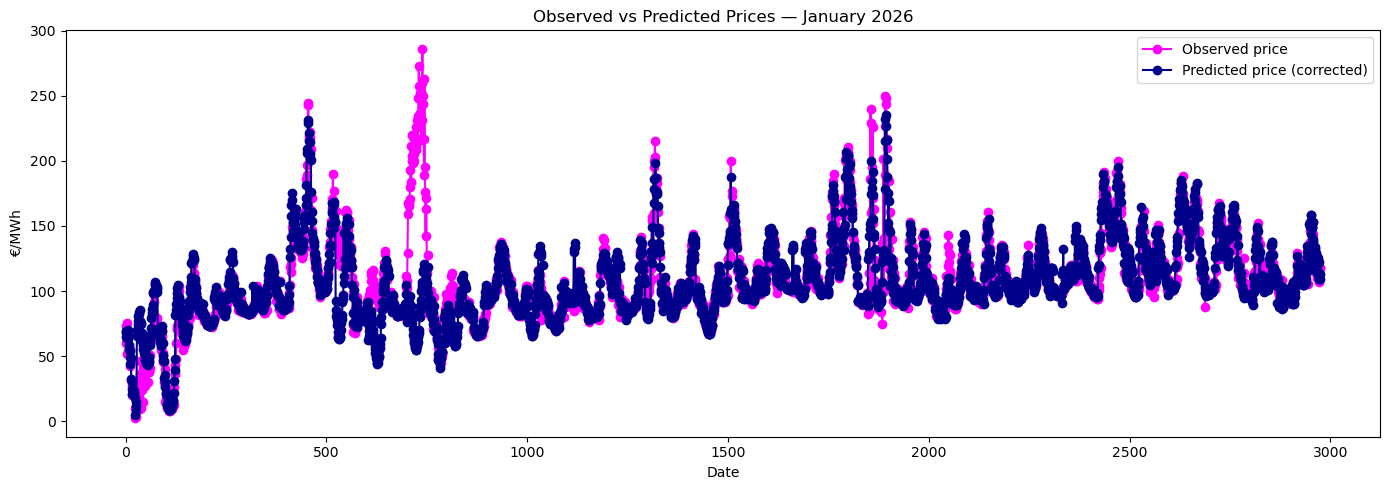

In [127]:
plt.figure(figsize=(14,5))
plt.plot(price_load_jan2026.index, price_load_jan2026["price"],color='fuchsia', marker='o', label="Observed price")
plt.plot(price_load_jan2026.index, price_load_jan2026_corrected["price_hat_corrected"],color='darkblue', marker='o', label="Predicted price (corrected)")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.title("Observed vs Predicted Prices — January 2026")
plt.legend()
plt.tight_layout()
plt.show()